<center>Национальный исследовательский университет ИТМО<br/>Факультет информационных технологий и программирования<br/>Прикладная математика и информатика</center>

## <center>**Методы оптимизации**</center>
### <center>Отчёт по лабораторной работе №1</center>

<div style="text-align: right"><b>Работу выполнили:</b><br/>Левицкий Иван M32351<br/>Шпрайдун Лев M32351<br/>Рынк Артур М32351<br/><b>Преподаватель:</b><br/>Ким Станислав</div>

<center>Санкт-Петербург<br/>2023</center>


#**Постановка задачи и цели работы:**

№1) Реализовать градиентный спуск с постоянным шагом.

№2) Реализовать метод одномерного поиска и градиентный спуск на его основе.

№3-4) Проанализировать траекторию и в целом работу каждого градиентного спуска на двумерных квадратичных функциях. Показать отличия в работе методов на разных функциях и между собой.

№5) Реализовать генератор случайных квадратичных функций от n переменных с числом обусловленности k.

№6) Проанализировать работу градиентных спусков на рандомных функциях T(n, k) при разных n и k.

№7) Множественный эксперимент №6.

№8 (Доп задание)) Реализовать градиентный спуск с условиями Вольфе и проанализировать его работу в сравнении с предыдущими методами.

**Работа выполнена при помощи следующих библиотек:**

 1) numpy (в основном исключительно для упрощения операций над матрицами и массивами)

 2) matplotlib.pyplot для отрисовки графиков

Для вычисления градиента во всех ф-циях написана собственная ф-ция 'grad' стандартным образом вычисляющая градиент с заданной точностью $ϵ = epsgrad$ - по дефолту равной $10^{-5}$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (21,8)

#Градиент (от ф-ций в произвольной форме)
def grad(f, x, eps):
  ans=np.zeros(x.shape[0])
  for i in range(0, x.shape[0]):
    arr=np.zeros(x.shape[0])
    arr[i]=eps
    ans[i]=(f(x+arr)-f(x-arr))/(2*eps);
  return ans

##**Общие факты про произвольный градиентный спуск.**

Основным принципом всех градиентных спусков является поиск минимума вдоль самого выгодного направления, а именно вдоль направления антиградиента.

Таким образом, каждая следующая точка (шаг) спуска строится по следующему соотношению:


$x_k = x_{k-1} - λ * Δf(x_{k-1})$,

**где λ = lr - некоторый коэффициент, подбор которого и отличает различные виды спуска друг от друга.**

*Критерии останова:*

Входными данными задается максимальное кол-во итераций спуска **'eposhs'** и желаемая точность **'eps_stop'** между последовательными шагами, для того, чтобы спуск останавливался в принципе и останавливался при достижении желаемой точности (т.к. уменьшается шаг и уменьшается модуль градиента)


###**№1) Градиентный спуск с фиксированным шагом.**

В этом градиентном спуске все тривиально - λ задается некоторой заранее выбранной константой и не меняется в ходе спуска.

Такой способ, очевидно, из простоты своего устройства очень редко оптимален и на определенных примерах с определенным шагом может вообще не сходится.

*Итого, алгоритм примитивен:*

Пересчитываем $x_k$ по формуле с заданным λ на каждой итерации и останавливаемся по критериям останова.

In [ ]:
х#Градиентный спуск с фиксированным шагом (для функции с произвольным числом аргументов).

def gradient_descent_with_constant_step(
    f, start_arg, lr, epochs, eps_stop = 1e-5, eps_grad=1e-5, is_plot = False,
    start_linspace=-1, stop_linspace=1, num=25, custom_plt=plt
     ):
  cur = np.array(start_arg, float)
  points = [cur]
  i = 0
  while (i < epochs and (i == 0 or abs(f(cur) - f(points[i - 1])) > eps_stop)):
    cur = cur - lr * grad(f, cur, eps_grad)
    points.append(cur)
    i+=1
  # print("number of steps: ", f(cur))
  if is_plot:
    print_gradient_work(np.array(points), f, start_linspace, stop_linspace, num, custom_plt)
  return (f(cur), i)

In [ ]:
def print_gradient_work(points, f, start_linspace, stop_linspace, num, custom_plt=plt):
  custom_plt.plot(points[:, 0], points[:, 1], 'o-')
  t = np.linspace(start_linspace, stop_linspace, num)
  X = np.meshgrid(t, t)
  print(points)
  custom_plt.contour(X[0], X[1], f(X), levels=np.sort(np.concatenate((f(points.T), t))))

###**№2) Градиентный спуск с одномерным поиском на основе дихотомии.**

Данный спуск сильно оптимальнее предыдущего, т.к. использует не константную Λ, а найденную методом дихотомии.

Сам **метод дихотомии** рассмотрим сразу на примере написанной ф-ции 'bin_search_lr(args)'.

*Входные данные:*

одномерная вдоль направления антиградиента ф-ция $g$, такая что $g(λ) = f(x_{k-1} - λ * Δf(x_{k-1}))$,

$left = 0$ - левая общая стартовая граница дихотомии (крайний случай соответствующий значению текущего шага на ф-ции $f$)

$right = maxlr$ - правая общая стартовая граница дихотомии (некоторая большая константа, обычно недостижимая или достижимая в случае бесконечно убывающей ф-ции - случай который нам не интересен)

$alp$ - половина длины отрезка на шаге итерации

$eps$ - заданная желаемая точность (критерий останова)

$max count$ - макс кол-во итераций алгоритма (критерий останова)

*Алгоритм:*

Шаг 1) Создание рассматриваемого подотрезка $[a, b]$, методом половинного деления и сдвигом на $alp$ в разные стороны $⇔ a = \frac{left + right}{2} - alp, b = \frac{left + right}{2} + alp$

Шаг 2) Если $g(a) > g(b)$, то $left = a$, иначе $right = b$ ⇔ изменение общего отрезка поиска

Шаг 3) Если текущая итерация $>= maxcount$ или мы достигли желаемой точности $eps$, то **ОСТАНОВА** и возврат $λ == left$, иначе переходим к шагу 1.

Таким образом, дихотомия, по приципу схожему с бинпоиском, ищет наиболее выгодное λ.


\\
В остальном градиентный спуск алгоритмически не изменился, но с точки зрения внутренней работы у него гораздо реже происходит вычисление градиента, т.к. в ходе дихотомии мы без пересчета градиента выбираем гораздо более выгодную λ, и нам требуется меньшее число шагов для сходимости.



In [ ]:
#Градиентный спуск с одномерной оптимизацией на основе дихотомии.

def bin_search_lr(g, max_lr, alp, eps, max_count):
  right = 100
  left = 0
  count = 0
  while right - left > eps and count < max_count:
    count += 1
    medium = (right + left) / 2
    a = medium - alp
    b = medium + alp
    if (g(a) > g(b)):
      left = a
    else:
      right = b
  return left

def gradient_descent_with_bin_search(
    f, start_arg, epochs, max_lr = 100, alp = 0.0001, eps_search = 0.0001, max_count = 100, eps_grad=1e-5,
    eps_stop=1e-5, is_plot = False, start_linspace=-1, stop_linspace=1, num=25, custom_plt=plt
     ):
  cur = np.array(start_arg, float)
  points = [cur]
  i=0
  while(i < epochs and (i == 0 or abs(f(cur) - f(points[i - 1])) > eps_stop)):
    gr = grad(f, cur, eps_grad)
    g = lambda lr : f(cur - lr * gr)
    cur = cur - bin_search_lr(g, max_lr, alp, eps_search, max_count) * gr
    points.append(cur)
    i+=1
  if is_plot:
    print_gradient_work(np.array(points), f, start_linspace, stop_linspace, num, custom_plt)
  return (f(cur), i)


###**№3) Анализ траектории работы градиентных спусков.**

В экспериментах ниже показана в сравнении работа двух градиентных спусков, причем в каждом из экспериментов шаг для функции подобран оптимально. Помимо того, что точность результата спуска методом дихотомии всегда лучше, можно заметить различия в траектории, особенно выраженное на первых шагах. Поскольку во второй функции шаг константен, при первых шагах, где градиент большой, шаг перескакивает минимум, из-за чего путь получается сильно дерганным, а в первом градиенте, засчет поиска оптимальной длинны шага, эта проблема не так выраженна.

[[-1.00000000e+00  1.00000000e+00]
 [-5.87655086e-02  9.23683690e-01]
 [-1.21749859e-01  1.19837159e-01]
 [-7.09559794e-03  1.10844413e-01]
 [-1.44254257e-02  1.39677981e-02]
 [-8.33406891e-04  1.29383131e-02]
 [-1.66156171e-03  1.58171343e-03]
 [-9.51150823e-05  1.46735698e-03]]
(6.221643734224225e-07, 7)


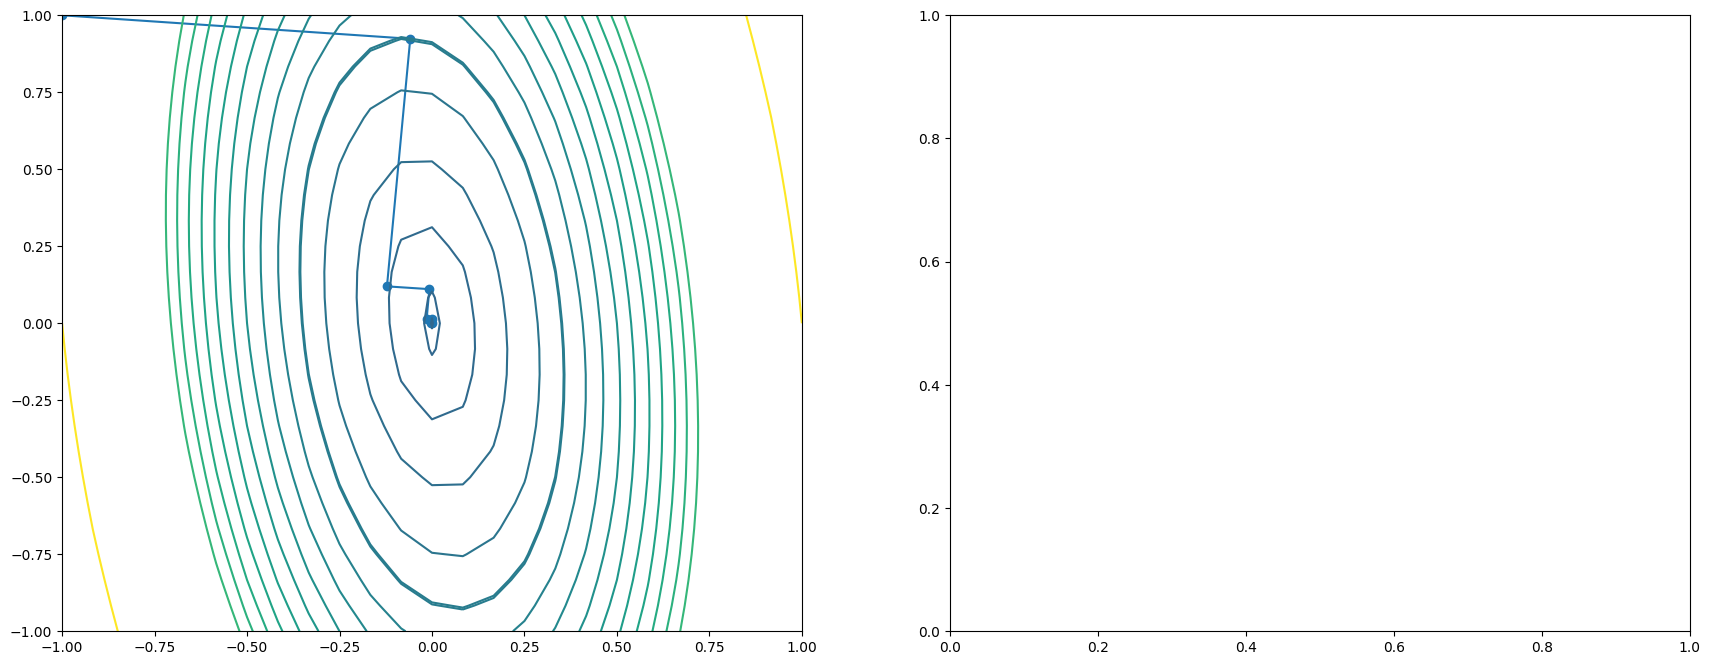

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)

f = lambda x : 2 * x[0] ** 2 + 0.3 * x[0] * x[1] + 0.3 * x[1] ** 2
print(gradient_descent_with_bin_search(f, [-1, 1], 30, is_plot=True, custom_plt=ax1))
# print(gradient_descent_with_constant_step(f, [-1, 1], 0.4, 30, is_plot=True, custom_plt=ax2))

(2.838743893525916e-07, 4)
(0.004883162891710965, 30)


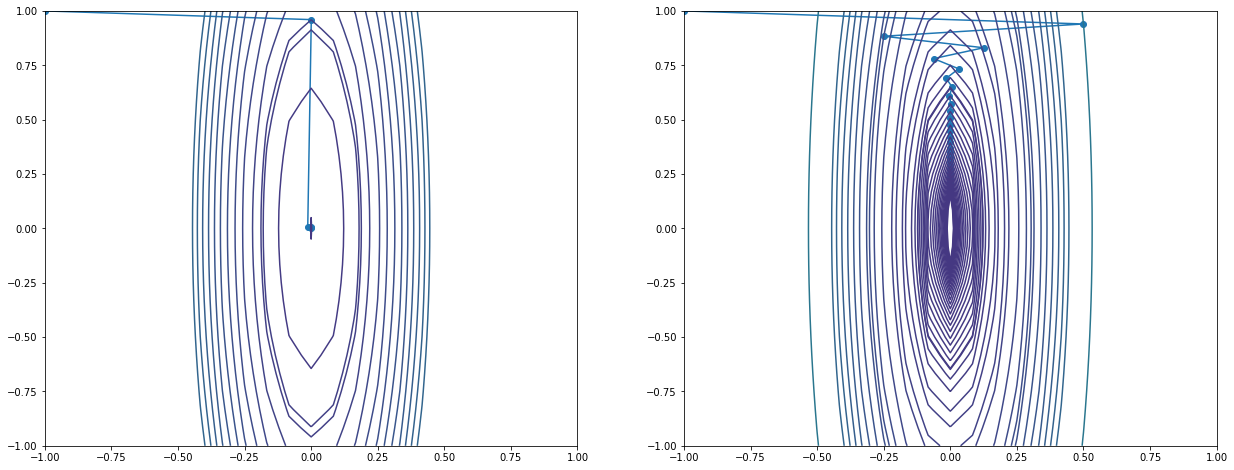

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
f = lambda x : 5 * x[0] ** 2 + 0.2 * x[1] ** 2
print(gradient_descent_with_bin_search(f, [-1, 1], 30, is_plot=True, custom_plt=ax1))
print(gradient_descent_with_constant_step(f, [-1, 1], 0.15, 30, is_plot=True, custom_plt=ax2))

(7.000000069815624, 4)
(7.002446178932901, 30)


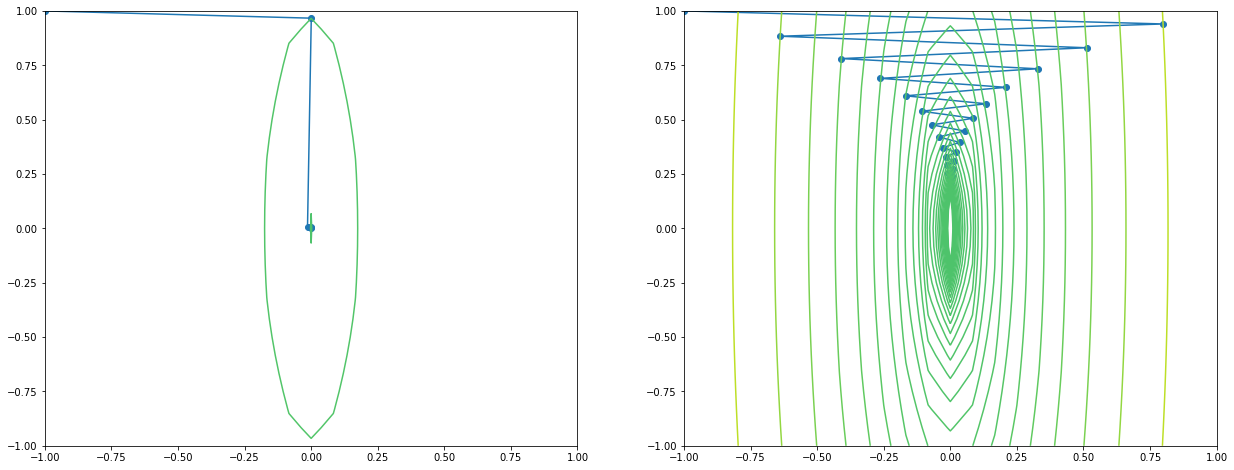

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)

f = lambda x: 3 * x[0] ** 2 + 0.1 * x[1] ** 2 + 7

print(gradient_descent_with_bin_search(f, [-1, 1], 30, is_plot=True, custom_plt=ax1))
print(gradient_descent_with_constant_step(f, [-1, 1], 0.3, 30, is_plot=True, custom_plt=ax2))

###**№4) Сравнение работы градиентных спусков по различным параметрам.**

####**4a) Сходимость градиентного спуска с постоянным шагом.**

Исследование сходимости рассмотрим на примере одной из функций выше. Рассмотрим сходимость при различный значениях шага. При 0.05 функция идет по правильной траектории, но даже при большом градиенте шаги маленькие, не говоря про более близкую окресность минимума. Из-за этого точность результата будет сильно страдать. При шаге 0.2 поиск движется по неправильной траектории, каждый раз "перепрыгивая" точку минимума, тем самым сохраняя или увеличивая градиент, что может привести к отдалению от локального минимума. При оптимальном для данной функции шаге 0.1 мы видим относительно правильную траекторию и скорость лучшую чем в первом случае, но по сравнению с результатом спуска методом дихотомии из прошлого номера заметный проигрыш как по траектории, так и по скорости.  

0.059510628538712904
0.004883162891710965
5.001343691794613


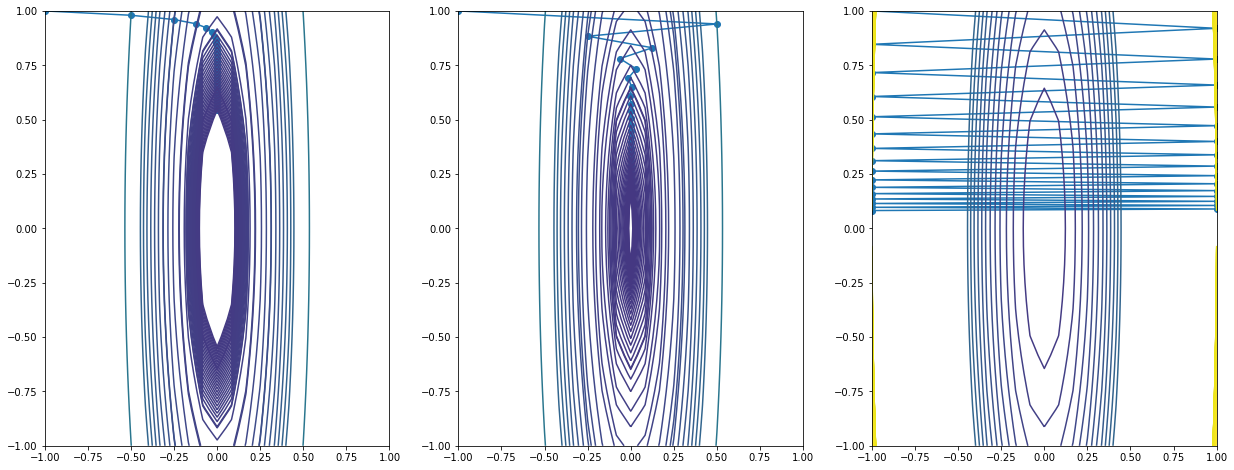

In [ ]:
#4a
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
f = lambda x : 5 * x[0] ** 2 + 0.2 * x[1] ** 2
print(gradient_descent_with_constant_step(f, [-1, 1], 0.05, 30, is_plot=True, custom_plt=ax1)[0])
print(gradient_descent_with_constant_step(f, [-1, 1], 0.15, 30, is_plot=True, custom_plt=ax2)[0])
print(gradient_descent_with_constant_step(f, [-1, 1], 0.2, 30, is_plot=True, custom_plt=ax3)[0])

val is:  -14.999890009767963 number of steps is:  79
val is:  -14.993297438122184 number of steps is:  100
val is:  -14.999920917019875 number of steps is:  28


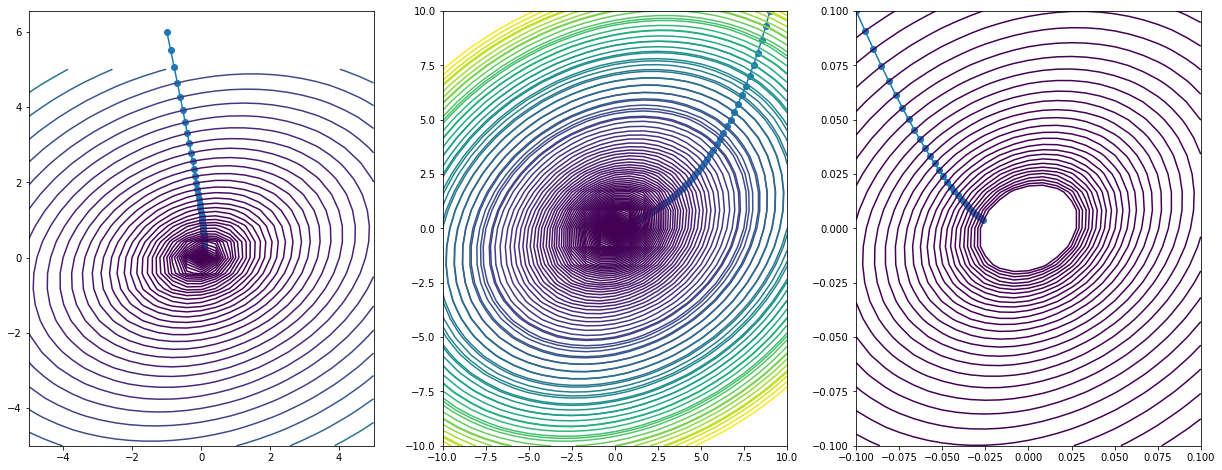

In [ ]:
#different start position with about normal lambda
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
(val, iter) = gradient_descent_with_constant_step(lambda x : 0.1 * x[0] ** 2 - 0.06 * x[0] * x[1] + 0.2 * x[1] ** 2 - 15, [-1, 6], 0.2, 100, is_plot=True, start_linspace=-5, stop_linspace=5, custom_plt=ax1)
print("val is: ", val, "number of steps is: ", iter)
(val, iter) = gradient_descent_with_constant_step(lambda x : 0.1 * x[0] ** 2 - 0.06 * x[0] * x[1] + 0.2 * x[1] ** 2 - 15, [9, 10], 0.2, 100, is_plot=True, start_linspace=-10, stop_linspace=10, custom_plt=ax2)
print("val is: ", val, "number of steps is: ", iter)
(val, iter) = gradient_descent_with_constant_step(lambda x : 0.1 * x[0] ** 2 - 0.06 * x[0] * x[1] + 0.2 * x[1] ** 2 - 15, [-0.1, 0.1], 0.2, 100, is_plot=True, start_linspace=-0.1 , stop_linspace=0.1, custom_plt=ax3)
print("val is: ", val, "number of steps is: ", iter)
#значит с норм лямбдой на таких функциях он работает норм примерно из любой начальной точки, с огворкой на скорость нахождения

####**4b) Анализ эффективности градиентного спуска с использованием одномерного поиска по кол-ву вычислений.**

Рассмотрим какое количество шагов делает градиентный спуск при задании определенной точности. Проведем для двух функций по три замера с разной точностью. В каждом из случаев более оптимальное решение проблемы показывает спуск методом дихотомии, с количеством шагов в несколько раз меньше. Происходит это по причине того, что при достаточно маленьком градиенте, фиксированное значение шага становиться маленьким и скорость приближения уменьшается.

In [ ]:
#4b
#одна функция с заданной точностью для функций с двумя разными градиентными спусками

def four_b(f):
  fig, (ax1, ax2) = plt.subplots(1, 2)
  print("First experiment")
  print("number of steps of gradient desent with bin search", gradient_descent_with_bin_search(f, [-1, 1], 1000000, eps_stop=1e-5, is_plot=True, custom_plt=ax1)[1])
  print("number of steps of gradient desent with bin constant step", gradient_descent_with_constant_step(f, [-1, 1], 0.1, 10000000, eps_stop=1e-5, is_plot=True, custom_plt=ax2)[1])
  print("\n", "Second experiment")
  print("number of steps of gradient desent with bin search", gradient_descent_with_bin_search(f, [-1, 1], 1000000, eps_stop=1e-7)[1])
  print("number of steps of gradient desent with bin constant step", gradient_descent_with_constant_step(f, [-1, 1], 0.1, 10000000, eps_stop=1e-7)[1])
  print("\n", "Third experiment")
  print("number of steps of gradient desent with bin search", gradient_descent_with_bin_search(f, [-1, 1], 1000000, eps_stop=1e-15)[1])
  print("number of steps of gradient desent with bin constant step", gradient_descent_with_constant_step(f, [-10, 10], 0.1, 10000000, eps_stop=1e-15)[1])
#очев где будет меньше шагов, а соответственно и вычислений градиента, ведь в этих функциях это равные величины, по скромной выборке видна тенденция к увеличению разницы при увеличении точности

First experiment
number of steps of gradiebt desent with bin search 5
number of steps of gradiebt desent with bin constant step 13

 Second experiment
number of steps of gradiebt desent with bin search 7
number of steps of gradiebt desent with bin constant step 18

 Third experiment
number of steps of gradiebt desent with bin search 12
number of steps of gradiebt desent with bin constant step 40


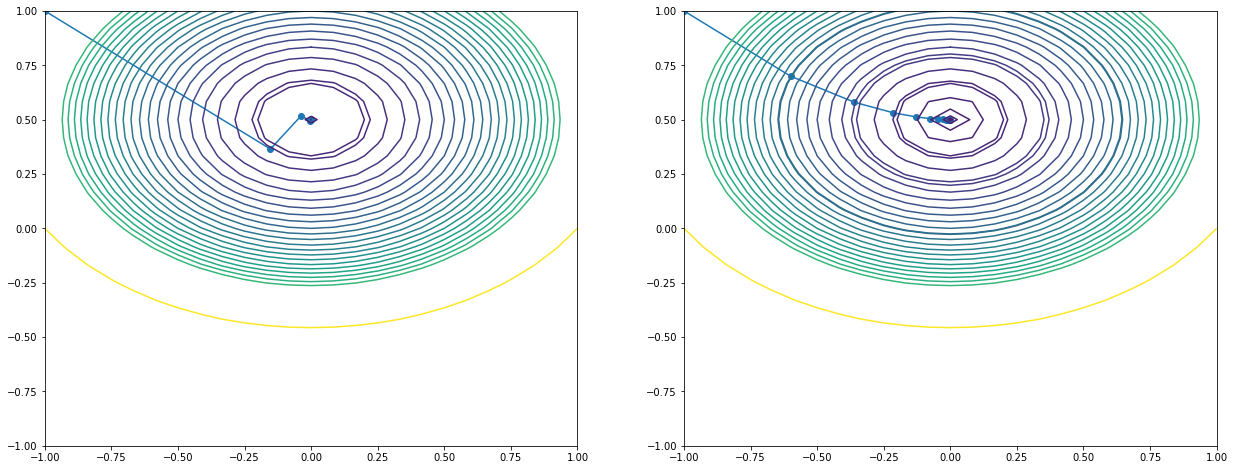

In [ ]:
f1 = lambda x : 2 * x[0] ** 2 - 3 * x[1] + 3 * x[1] ** 2
four_b(f1)

First experiment
number of steps of gradiebt desent with bin search 3
number of steps of gradiebt desent with bin constant step 6

 Second experiment
number of steps of gradiebt desent with bin search 3
number of steps of gradiebt desent with bin constant step 7

 Third experiment
number of steps of gradiebt desent with bin search 4
number of steps of gradiebt desent with bin constant step 14


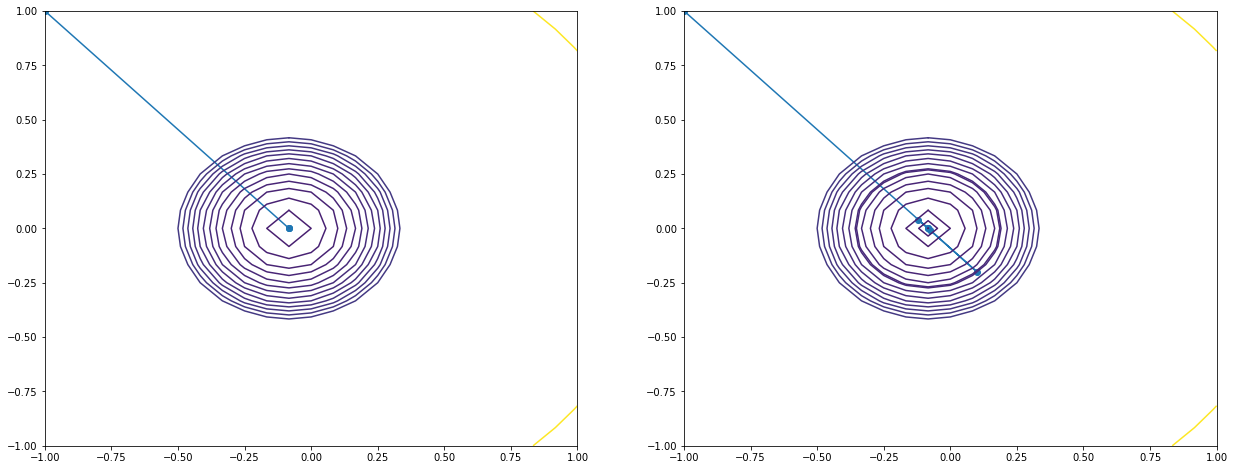

In [ ]:
f1 = lambda x : 6 * x[0] ** 2 + x[0] + 3 * x[1] * x[1] + 3 * x[1] ** 2
four_b(f1)

####**4c) Выбор различных стартовых точек.**

Исследуем работу градиентов при выборе разных стартовых точек. Для каждой из трех функций проведем по четыре замера, один на очень близкой к ответу стартовой точке, другой подальше и третий совсем далеко. Из экспериментов видно, что оба спуска сходятся, и, что логично, количество шагов растет. Но рост количества шагов у спуска методом дихотомии значительно меньше, ведь мы вибираем размер шага и быстро приближаемся к миниму при отдаленном значении, в отличие от константного шага. Но с константным шагом не так все плохо, ведь в "простых" функциях как в эксперименте, точки удаленные от локального минимума имеют большой градиент, что и компенсирует постоянный шаг.

In [ ]:
#4с

def four_c(f):
  fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2)
  print("First experiment")
  print("number of steps of gradient desent with bin search", gradient_descent_with_bin_search(f, [0.1, -0.01], 1000, eps_stop=1e-7, is_plot=True, start_linspace=-0.3, stop_linspace=0.3, custom_plt=ax1)[1])
  print("number of steps of gradient desent with bin constant step", gradient_descent_with_constant_step(f, [0.1, -0.01], 0.1, 1000, eps_stop=1e-7, is_plot=True, start_linspace=-0.3, stop_linspace=0.3, custom_plt=ax2)[1])
  print("\n", "Second experiment")
  print("number of steps of gradient desent with bin search", gradient_descent_with_bin_search(f, [44, 13], 1000, eps_stop=1e-7, is_plot=True, start_linspace=-13, stop_linspace=44, custom_plt=ax3)[1])
  print("number of steps of gradient desent with bin constant step", gradient_descent_with_constant_step(f, [44, 13], 0.1, 1000, eps_stop=1e-7, is_plot=True, start_linspace=-13, stop_linspace=44,  custom_plt=ax4)[1])
  print("\n", "Third experiment")
  print("number of steps of gradient desent with bin search", gradient_descent_with_bin_search(f, [-1122, 343], 1000, eps_stop=1e-7, is_plot=True, start_linspace=-1122, stop_linspace=343, custom_plt=ax5)[1])
  print("number of steps of gradient desent with bin constant step", gradient_descent_with_constant_step(f, [-1122, 343], 0.1, 1000, eps_stop=1e-7, start_linspace=-1122, stop_linspace=343, is_plot=True, custom_plt=ax6)[1])
  print("\n", "Fourth experiment")
  print("number of steps of gradient desent with bin search", gradient_descent_with_bin_search(f, [391414, 3234444], 1000, eps_stop=1e-7, is_plot=True, start_linspace=-391414, stop_linspace=3234444, custom_plt=ax7)[1])
  print("number of steps of gradient desent with bin constant step", gradient_descent_with_constant_step(f, [391414, 3234444], 0.1, 1000, eps_stop=1e-7, is_plot=True, start_linspace=-3234444, stop_linspace=3234444, custom_plt=ax8)[1])


First experiment
number of steps of gradiebt desent with bin search 5
number of steps of gradiebt desent with bin constant step 26

 Second experiment
number of steps of gradiebt desent with bin search 13
number of steps of gradiebt desent with bin constant step 55

 Third experiment
number of steps of gradiebt desent with bin search 8
number of steps of gradiebt desent with bin constant step 71

 Fourth experiment
number of steps of gradiebt desent with bin search 7
number of steps of gradiebt desent with bin constant step 99


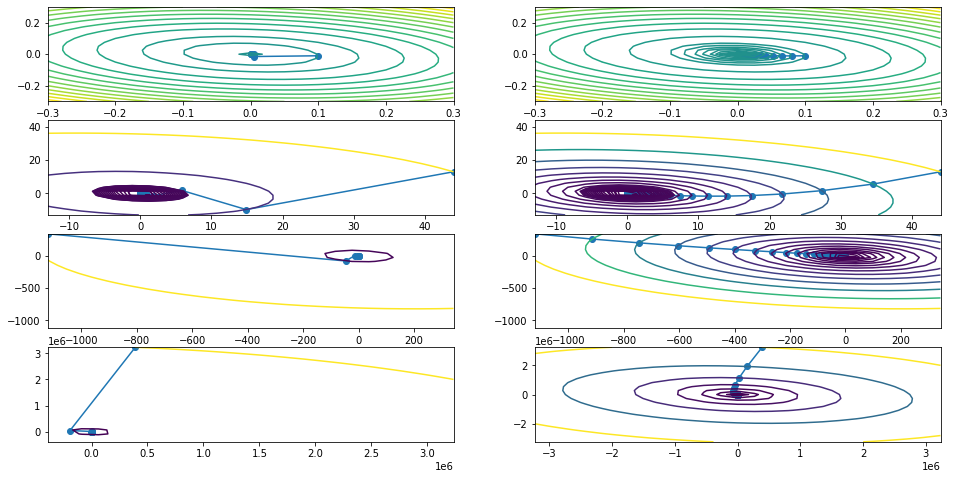

In [ ]:
f = lambda x : x[0] ** 2 + 0.5 * x[0] * x[1] + 2 * x[1] ** 2
four_c(f)

First experiment
number of steps of gradiebt desent with bin search 3
number of steps of gradiebt desent with bin constant step 23

 Second experiment
number of steps of gradiebt desent with bin search 8
number of steps of gradiebt desent with bin constant step 52

 Third experiment
number of steps of gradiebt desent with bin search 8
number of steps of gradiebt desent with bin constant step 79

 Fourth experiment
number of steps of gradiebt desent with bin search 48
number of steps of gradiebt desent with bin constant step 128


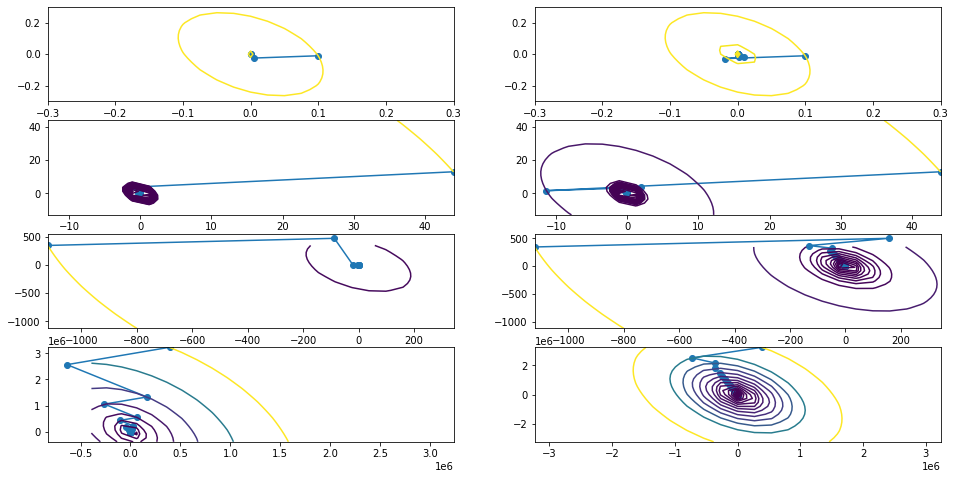

In [ ]:
f = lambda x : 6 * x[0] ** 2 + 2 * x[0] * x[1] + x[1] ** 2 + 4
four_c(f)

First experiment
number of steps of gradiebt desent with bin search 8
number of steps of gradiebt desent with bin constant step 18

 Second experiment
number of steps of gradiebt desent with bin search 16
number of steps of gradiebt desent with bin constant step 37

 Third experiment
number of steps of gradiebt desent with bin search 14
number of steps of gradiebt desent with bin constant step 46

 Fourth experiment
number of steps of gradiebt desent with bin search 19
number of steps of gradiebt desent with bin constant step 71


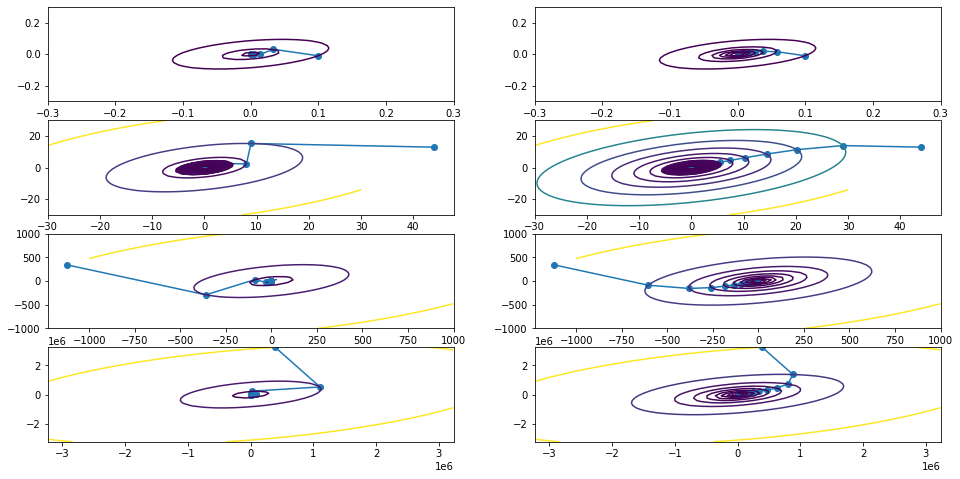

In [ ]:
f = lambda x : 2 * x[0] ** 2 - 2 * x[0] * x[1] + 3 * x[1] ** 2 - 21
four_c(f)

####**4d) Исследование влияния нормализации (skaling).**

Исследуем влияние масштабирования на работу градиентного спуска на двух функциях с плохой обусловленностью, то есть растянутыми по одной оси, и сравним с их нормализованными версиями. Эксперименты ниже четко показывают различия работы каждого из спусков при масштабировании функции. Большее влияние оказывается на спуск с постоянным шагом, но как и в случае спуска методом дихотомии это происходит из-за не оптимального значения градиента. Так как функция может меняться при изменение аргумента как несущественно, так и очень сильно, градиент может иметь слишком малое значение, из-за чего пострадает точность, или слишком большое, из-за чего будет постоянно перешагиваться искомая точка.

In [ ]:
#4d

def four_d(f, normalized_f):
  fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
  print("Not normalized")
  print(gradient_descent_with_bin_search(f, [-1, 1], 30, is_plot=True, eps_stop=1e-6, custom_plt=ax1, num=12)[0])
  print(gradient_descent_with_constant_step(f, [-1, 1], 0.001, 30, is_plot=True, eps_stop=1e-6, custom_plt=ax2, num=12)[0])
  print("Normalized")
  print(gradient_descent_with_bin_search(normalized_f, [-1, 1], 30, is_plot=True, eps_stop=1e-6, custom_plt=ax3)[0])
  print(gradient_descent_with_constant_step(normalized_f, [-1, 1], 0.5, 30, is_plot=True, eps_stop=1e-6, custom_plt=ax4)[0])

Not normalized
1.4579477929170328e-06
0.9766643855438364
Normalized
1.802635377887631e-08
1.1920928954988444e-07


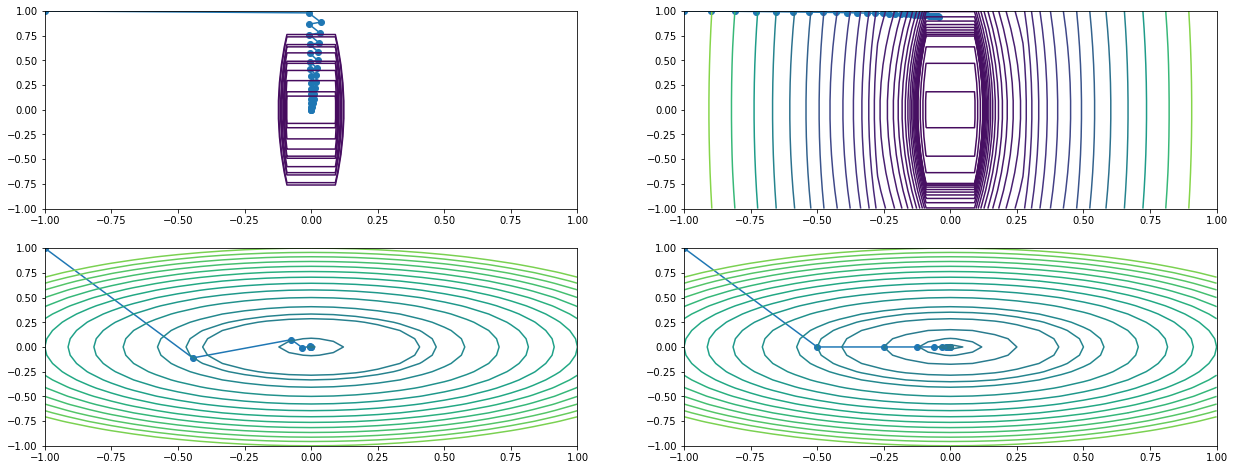

In [ ]:
f = lambda x : 50 * x[0] ** 2 + x[1] ** 2
normalized_f = lambda x : 50 * (x[0] / 10) ** 2 + x[1] ** 2
four_d(f, normalized_f)

Not normalized
1.8353812680109967e-05
0.4640884238639941
Normalized
3.976389157809047e-09
1.1784855613050577e-07


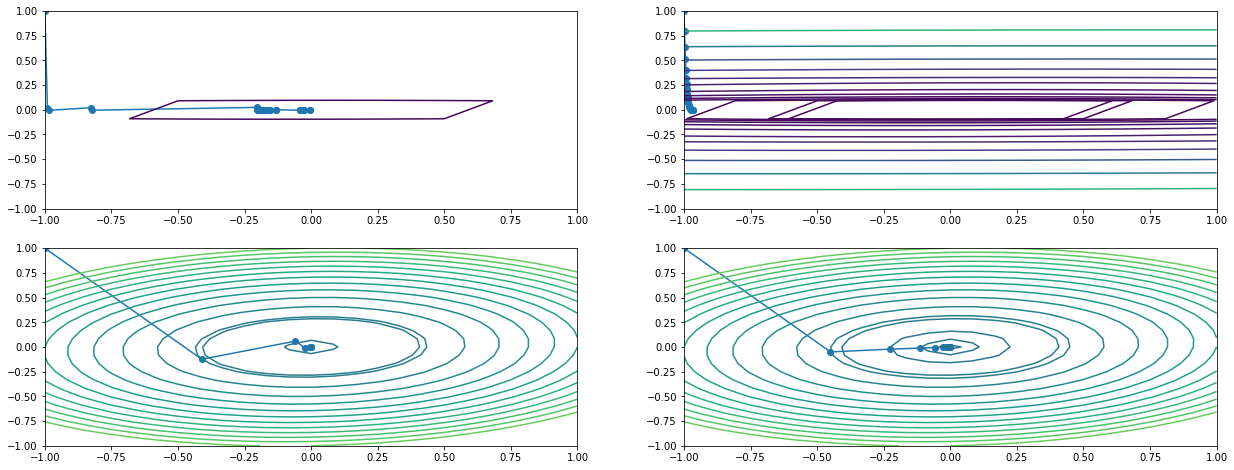

In [ ]:
f = lambda x : 0.5 * x[0] ** 2 - x[0] * x[1] + 100 * x[1] ** 2
normalized_f = lambda x : 0.5 * x[0] ** 2 - x[0] * (x[1]/10) + 100 * (x[1]/10) ** 2
four_d(f, normalized_f)

###**№5) Генератор случайных квадратичных ф-ций произвольной размерности с заданным числом обусловленности.**

Переформулируем задание на язык матриц - нужно сгенерировать случайную матрицу размера $n \times n$ c заданным числом обусловленности $k$.

 Мы можем так переформулировать, так как знаем что матрица $A$ в записи $X * A * X^{T}$ (где $X$ - вектор аргументов $x_0, x_1, …, x_n$) как раз задает квадратичную функцию $\displaystyle\sum_{i < j}^{} (a_{ij} + a_{ji})x_ix_j + \displaystyle\sum_{i=1}^{n} a_{ii}x_i^2$. То есть матрица способна задать произвольную квадратичную функцию и наоборот. (Заметим, что это достаточно легко отображается кодом на python, т.к. теперь мы будем записывать квадратичную функцию как $f(x) = x @ A @ x$, где $A$ - некоторая заранее определенная матрица коэффициентов).

Сгенерировать матрицу случайных чисел $n \times n$ не представляет труда, но нам нужно соблюсти условие на число обусловленности.

Число обусловленности матрицы ($k$) - это $|\frac{λ_{max}}{λ_{min}}|$, где $λ_{max}$ - максимальное по модулю собственное число м-цы, а $λ_{min}$ - минимальное. Из этого можно сказать, что если наше $k$ - натуральное (а нам на вход дают именно такие), то мы можем смело взять такую матрицу, где одно собственное число в точности равно $k$, другое в точности равно $1$, а все остальные находятся в промежутке между ними (нам асимптотически абсолютно не важно то, что отношение $k$ достигается имеенно в виде $|\frac{k}{1}|$).

Генерировать рандомную матрицу с заданными собственными числами сходу не представляется возможным, поэтому сначала рандомно сгенерируем такую матрицу у которой понятны собственные числа, а именно - диагональную. Для этого просто генерируем рандомный список чисел от $1$ до $k$ размера $n$, поменяв максимальное и минимальное значение на соответственно $1$ и $k$, и создаем по нему матрицу $D$ (по сути мы сгенерировали случайное мн-во собственных чисел с заданным условием и сохранили эту информацию в виде конкретной диагональной матрицы).

Далее нам нужно просто, не изменив собственных чисел, создать по нему рандомную матрицу. Для этого мы используем разложение $A = QDQ^T$, где $Q$ - ортогональная матрица ($⇔ Q^{-1} = Q^T$); $Q$ - ортог, т.к. не должна содержать равных векторов и на случай если в $D$ сгенерировались одинаковые с.ч., т.к. произвольная матрица - в лучшем случае соответствовала бы спектральному разложению, а значит тольку классу диагонализируемых м-ц, нам же нужна произвольная.

Случайную ортогональную матрицу $Q$ мы создадим просто, сгенерировав случайную матрицу и взяв от нее $QR$ разложение с помощью метода numpy.linalg.qr(), где Q - ортогональная, а R - верхне-треугольная (это не отнимет больше $n^2$ времени т.к. внутри реализовано, что-то не хуже метода Грамма-Шмидта).

Итого у нас получится случайная матрица $A = QDQ^T$ с заданным числом обусловленности $k$.


In [ ]:
def gen_random_orthogonal_matrix(n, rg = 100000000000):
  m = np.random.randint(-rg, rg, (n, n))
  return np.linalg.qr(m)[0]

def gen_random_q_fun(n, k):
  cortege = np.random.random(n) * (k - 1) + 1
  cortege[np.where(np.isclose(cortege, np.amin(cortege)))[0][0]] = 1
  cortege[np.where(np.isclose(cortege, np.amax(cortege)))[0][0]] = k
  diag_matrix = np.diag(cortege)
  ortogonal_matrix = gen_random_orthogonal_matrix(n)
  return ortogonal_matrix @ diag_matrix @ np.transpose(ortogonal_matrix)

Продемонстрируем корректность генерации в смысле числа обусловленности на некоторых примерах с помощью ф-ции numpy.linalg.cond(matrix) - возвращающей число обусловленности matrix

In [ ]:
print(np.round(np.linalg.cond(gen_random_q_fun(2, 2))) == 2)
print(np.round(np.linalg.cond(gen_random_q_fun(3, 3))) == 3)
print(np.round(np.linalg.cond(gen_random_q_fun(5, 10))) == 10)
print(np.round(np.linalg.cond(gen_random_q_fun(10, 5))) == 5)
print(np.round(np.linalg.cond(gen_random_q_fun(10, 10))) == 10)
print(np.round(np.linalg.cond(gen_random_q_fun(10, 100))) == 100)
print(np.round(np.linalg.cond(gen_random_q_fun(100, 100))) == 100)
print(np.round(np.linalg.cond(gen_random_q_fun(500, 50))) == 50)
print(np.round(np.linalg.cond(gen_random_q_fun(800, 700))) == 700)
print(np.round(np.linalg.cond(gen_random_q_fun(1000, 999))) == 999)
print(np.round(np.linalg.cond(gen_random_q_fun(1000, 1000))) == 1000)
print(np.round(np.linalg.cond(gen_random_q_fun(1000, 257))) == 257)
print(np.round(np.linalg.cond(gen_random_q_fun(1000, 1))) == 1)

True
True
True
True
True
True
True
True
True
True
True
True
True


###**№6) Исследование зависимости числа итераций, необходимых градиентному спуску для сходимости на рандомных ф-циях с заданным числом обусловленности в зависимости от размерности пр-ва (без усреднения).**

Проведем 3 серии экспериментов (без усреднения) при разных порядковых значениях $n$ $(10, 100, 1000)$ (дабы не строить трехмерных графиков) и соответственно 20 различных $k_i ∈ [2, 1000]$ разбросанных на равные расстояния друг от друга.

In [ ]:
def test(n, k):
  val = gen_random_q_fun(n, k)
  start = np.ones(n)
  return gradient_descent_with_bin_search(lambda x : (x@val@x), start, 1000)[1]

In [ ]:
def six_test(n):
  points_x=[]
  points_y=[]
  for k in np.linspace(1, 1000, 20):
    points_x.append([k])
    points_y.append(test(n, k))
  plt.plot(points_x, points_y, 'o-')


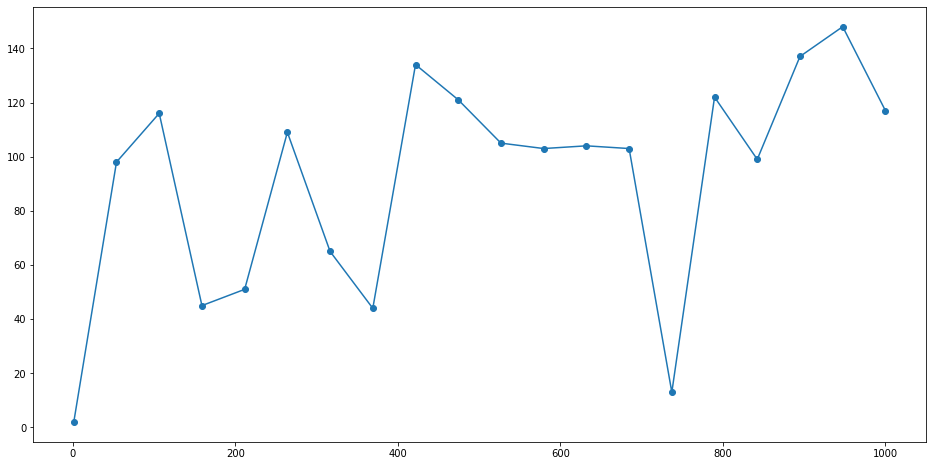

In [ ]:
six_test(10)

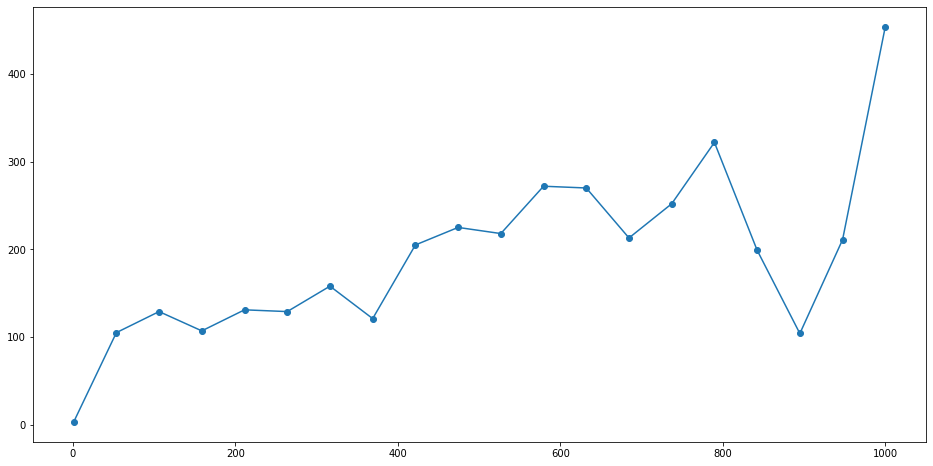

In [ ]:
six_test(100)

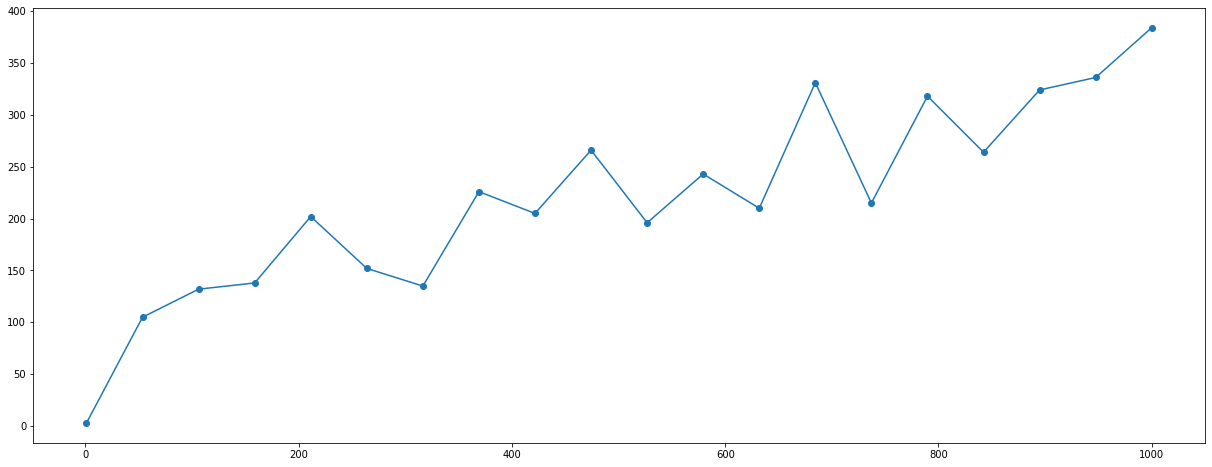

In [ ]:
six_test(1000)

Таким образом мы получили 3 графика на каждом из которых отражена зависимость (при фиксированном $n$) между числом обусловленности $k$ и числом итераций спуска до требуемой точности. В целом на всех графиках уже видна тенденция к линейному росту, но случаются резкие колебания вниз (скорее всего из-за всегда одной и той же заранее выбранной стартовой точки для разных рандомных ф-ций и отсутствии усреднения). А также видна чуть менее прогрессивная тенденция к росту от размерности n между графиками.

Проведем сразу эксперимент с множественной выборкой и более подробно распишем выводы после него.

###**№7) Исследование зависимости числа итераций, необходимых градиентному спуску для сходимости на рандомных ф-циях с заданным числом обусловленности в зависимости от размерности пр-ва (с усреднением).**


Проводим 3 серии экспериментов из №6, но теперь при конкретных $n, k$ будем запускать 50 экспериментов и брать среднее арифметическое их результата - таким образом мы избавимся от существенных скачков и более строго отобразим зависимость.

In [ ]:
def seven_test(n, count=20):
  points_x=[]
  points_y=[]
  for k in np.linspace(1, 1000, 20):
    points_x.append([k])
    cur = 0
    for i in range(0, count):
      cur += test(n, k)
    points_y.append(cur/count)
  plt.plot(points_x, points_y, 'o-')

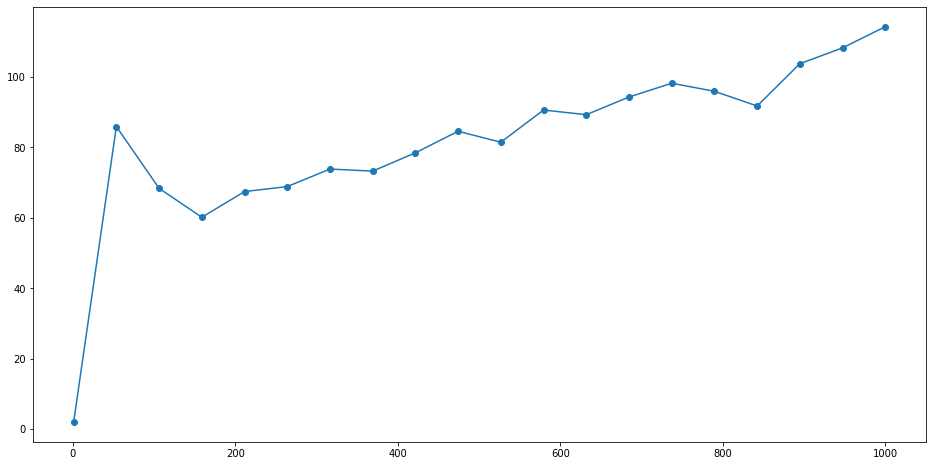

In [ ]:
seven_test(10, 100)

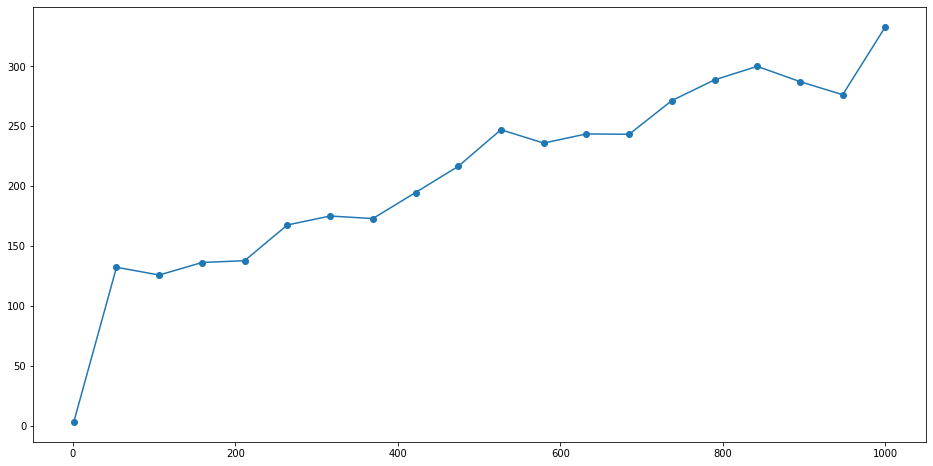

In [ ]:
seven_test(100, 100)

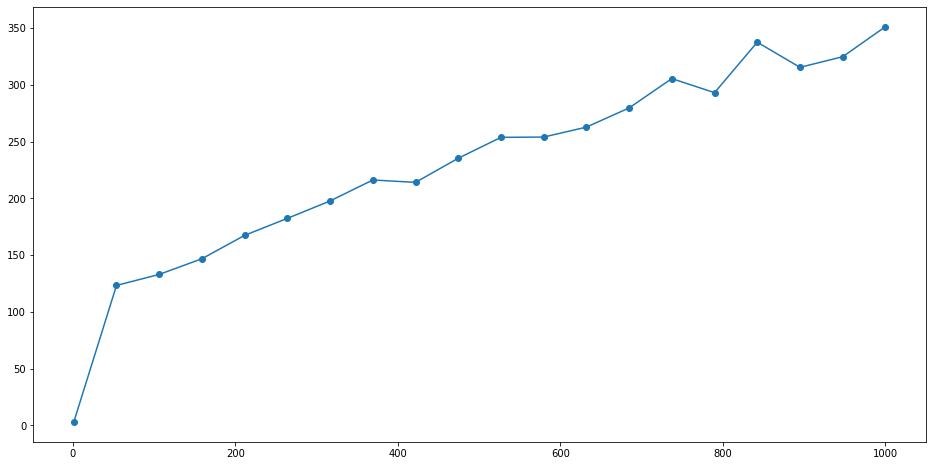

In [ ]:
seven_test(1000, 100)

Итого:

1) Можно видеть зависимость между максимальными значениями числа итераций на различных графиках в зависимости от $n$ (особенно видна разница между $n = 10$ и $n = 100$). Это можно объяснить тем, что более многомерные ф-ции в целом сложнее и расстояния между рассматриваемыми шагами в среднем больше.

2) Основной рассматриваемой и демонстрирующейся на графиках зависимостью является средний асимптотически линейный рост числа итераций от увеличения числа обусловленнности. Математически это понятно из того, что число обусловленности напрямую влияет на максимальную возможность изменения значения ф-ции при малом изменении аргумента, а значит градиентный спуск в ф-циях (особенно достаточно многомерных) зачастую вынужден уменьшать шаг или начинает чаще перескакивать оптимальные точки (да и сам градиент вычисляется несколько менее точно при заданном $eps$).

###**№8) Градиентный спуск с одномерной оптимизацией на основе условий Вольфа и анализ его работы.**

Этот спуск примечателен тем, что выбирает λ на каждом шаге с помощью достаточно сложных математических условий, а именно условий Вольфа:

(переписаны в терминах того, что $p_k$ - всегда направление антиградиента, то есть $p_k = -Δf(x_k)$)

Первое условие Вольфа: $f(x_k - λ_kΔf(x_k)) <= f(x_k) - c_1λ_kΔf(x_k)Δf(x_k)^T$

Второе условие Вольфа: $-Δf(x_k - λ_kΔf(x_k))Δf(x_k)^T >= -c_2Δf(x_k)Δf(x_k)^T$

Мы знаем (из теорем с лекций), что условия Вольфа в теории всегда достижимы и спуск с их выполнением наиболее выгоден, а значит, они хороши как условия останова одномерного поиска.

**Одномерный поиск с учетом условий Вольфа.**

*Входные данные:*

$f$ - исследуемая ф-ция

$lr = startlr$ - некоторое стартовое значение λ, от которого мы будем всегда итеративно сдвигаться

$alp < 1$ - коэффициент сдвига (по дефолту равен $1/2$)

$maxcount$ - максимальное число итераций алгоритма (хоть и всегда существует такое λ, что при нем условия вольфа выполняются - мы можем не найти его за приемлимое число шагов или вообще не найти, поэтому следует ограничить время поиска)

$*args$ - различная доп информация для проверки условий Вольфа и/или взятий градиента.

*Алгоритм:*

Шаг 1) Если не выполнено первое условие Вольфа сдвинем $λ = λ * alp$, иначе если первое условие выполнено, но не выполнено второе сдвинем $λ = λ * 2 *\frac{1}{alp}$, иначе выполнены оба условия и **ОСТАНОВА**.

Шаг 2) Проверяем условия останова, если оба условия вольфа выполняются или превышено число итераций - **ОСТАНОВА**, иначе Шаг 1.

Несложно заметить, что из-за соотношения $\frac{alp}{\frac{2}{alp}} = \frac{1}{2}$, мы опять же действуем аналогично бинпоиску на отрезке $[0, startlr]$ или отрезке $[startlr, +∞]$ в зависимости от стартового перехода и достаточно оптимально ищем λ, удовлетворяющую условиям Вольфа.



In [ ]:
def wolf_conditions(f, lr, gr_f, f_val, cur_with_lr, eps_grad, c1, c2):
  p_tr = np.transpose(-gr_f)
  return (f(cur_with_lr) <= f_val + c1 * lr * (gr_f @ p_tr),
          grad(f, cur_with_lr, eps_grad) @ p_tr >= c2 * gr_f @ p_tr)


def find_lr_on_wolfe_conditions(f, start_lr, alp, eps_grad, gr_f, cur, c1, c2, max_count=100):
  lr = start_lr
  f_val = f(cur)
  wolfe1, wolfe2 = (False, False)
  count = 0
  while((not wolfe1 or not wolfe2) and count < max_count):
    wolfe1, wolfe2 = wolf_conditions(f, lr, gr_f, f_val, cur - lr * gr_f, eps_grad, c1, c2)
    if not wolfe1:
      lr = lr * alp
    elif not wolfe2:
      lr = lr * 2/alp
    else:
      break
    count+=1
  return lr


def gradient_descent_with_wolfe_conditions_optimization(
    f, start_arg, epochs, start_lr=1, alp=0.5,
    eps_stop=1e-5, eps_grad=1e-5, c1=0.0001, c2=0.9, is_plot = False,
    start_linspace=-1, stop_linspace=1, num=25, custom_plt=plt
     ):
  cur = np.array(start_arg, float)
  points = [cur]
  i=0
  while(i < epochs and (i==0 or abs(f(cur) - f(points[i - 1])) > eps_stop)):
    gr = grad(f, cur, eps_grad)
    cur = cur - find_lr_on_wolfe_conditions(f, start_lr, alp, eps_grad, gr, cur, c1, c2) * gr
    points.append(cur)
    i+=1
  if is_plot:
    print_gradient_work(np.array(points), f, start_linspace, stop_linspace, num, custom_plt)
  return (f(cur), i)

Произведем эксперименты первых спусков для спуска с условиями Вольфа. Можем заметить, что такой спуск работает на несложных функциях лучше чем спуск с постоянным шагом, но хуже чем с бинарным поиском шага. Но заметим, что условия Вольфа не гарантируют более быстрого спуска, а просто наличие такого коэффицента, что он удовлетворяет условиям и гарантирует сходимость, так что выгоднее может оказаться поиск методом дихтомии.

val is:  3.151522299576676e-05 number of steps is:  11
val is:  0.0004960234963087088 number of steps is:  30
val is:  7.0030875012973155 number of steps is:  26


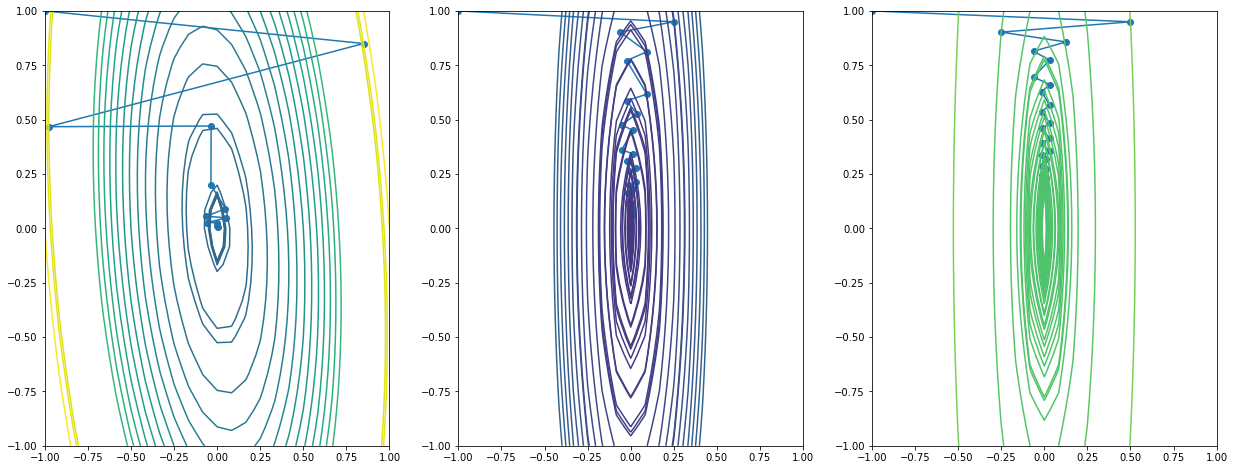

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

f = lambda x : 2 * x[0] ** 2 + 0.3 * x[0] * x[1] + 0.3 * x[1] ** 2
(val, iter) = gradient_descent_with_wolfe_conditions_optimization(f, [-1, 1], 30, is_plot=True, custom_plt=ax1)
print("val is: ", val, "number of steps is: ", iter)
f = lambda x : 5 * x[0] ** 2 + 0.2 * x[1] ** 2
(val, iter) = gradient_descent_with_wolfe_conditions_optimization(f, [-1, 1], 30, is_plot=True, custom_plt=ax2)
print("val is: ", val, "number of steps is: ", iter)
f = lambda x: 3 * x[0] ** 2 + 0.1 * x[1] ** 2 + 7
(val, iter) = gradient_descent_with_wolfe_conditions_optimization(f, [-1, 1], 30, is_plot=True, custom_plt=ax3)
print("val is: ", val, "number of steps is: ", iter)